### 自适应变化参数

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

def de2(fobj, bounds, popsize=20, its=1000, gap = 0.00001):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            select_idx = (np.random.choice(idxs, 3, replace = False)).tolist()
            fit_select = [fitness[i1] for i1 in select_idx]
            best1 = np.argmin(fit_select)
            others = [n for n in range(len(select_idx)) if n != best1]
            a = pop[select_idx[best1]]
            b = pop[select_idx[others[0]]]
            c = pop[select_idx[others[1]]]
            mut = 0.1 + (0.9 - 0.1)*((fitness[select_idx[others[0]]] - fitness[select_idx[best1]]) / (fitness[select_idx[others[1]]] - fitness[select_idx[best1]]))
            mutant = np.clip(a + mut * (b - c), 0, 1)
            crossp = 0.1
            if(fitness[j] > np.mean(fitness)):
                crossp = 0.1 + (0.6 - 0.1)*(fitness[j] - min(fitness) / (max(fitness) - min(fitness)))
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
        if(min(fitness) < gap):
            break
        yield best, fitness[best_idx]


### 固定参数

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

def de(fobj, bounds, mut=0.8, crossp=0.7, popsize=20, its=1000, gap = 0.00001):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), 0, 1)
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
        if(min(fitness) < gap):
            break    
        yield best, fitness[best_idx]

(array([ 1.47940284e-04,  1.00227272e-05, -9.25348406e-05, -3.69943652e-05,
       -1.62438097e-05, -1.02492736e-04,  2.47278711e-05,  8.00738110e-05,
       -3.92753523e-05,  1.63176651e-04]), 1.1735424932268756e-05)
0:00:04.953943


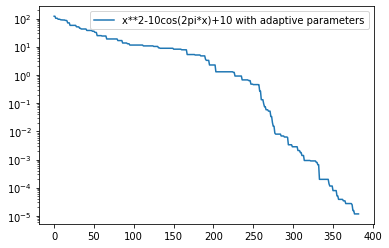

In [53]:
def fobj(x):
    return sum(x ** 2 - 10 * np.cos(2 * np.pi * x) + 10)

def fobj_test():
    it = list(de2(fobj, [(-10,10)] * 10, popsize = 100, its = 1000))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='x**2-10cos(2pi*x)+10 with adaptive parameters')
#     plt.xscale('log')
    plt.yscale('log')
    plt.legend() 
start = datetime.datetime.now()
fobj_test()
end = datetime.datetime.now()
print(end - start)

(array([-2.66769483e-02,  9.43635052e-04,  1.02766673e+00,  9.34290136e-01,
       -8.66666516e-01, -1.02639489e+00,  8.47230242e-01,  1.05279639e+00,
       -4.50733061e-02,  9.53768286e-01]), 16.675702821574717)
0:00:08.291343


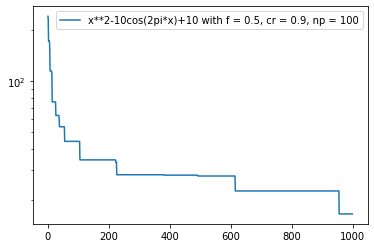

In [54]:
def fobj_test1():
    it = list(de(fobj, [(-10,10)] * 10, mut = 0.5, crossp = 0.9, popsize = 100, its = 1000))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='x**2-10cos(2pi*x)+10 with f = 0.5, cr = 0.9, np = 100')
#     plt.xscale('log')
    plt.yscale('log')
    plt.legend() 
start = datetime.datetime.now()
fobj_test1()
end = datetime.datetime.now()
print(end - start)

### 线性变化参数，设置cr

In [ ]:
#             mut = (0.9 - 0.4)*(its - i)/ its + 0.4 
#             crossp = 0.3 + (0.9 - 0.3) * (i / its)
#             mut = (0.9 - 0.4) * (its ** 2 - i ** 2) ** 0.5 / its + 0.4
#             crossp = 0.3 + (0.9 - 0.3) * (i ** 2 / its ** 2)